# Evaluation

## Evaluation of Retrievers

### Basic Retriever Quality Metrics

Key metrics include `precision and recall`, which assess the relevance of retrieved documents.

`Precision` is the ratio of relevant documents retrieved to the total documents retrieved, while `recall` measures the ratio of relevant documents retrieved to the total relevant documents available.

An example illustrates how adjustments to a retriever can affect precision and recall, highlighting the trade-off between the two.

`Precision` reflects the trustworthiness of results, while `recall` indicates the comprehensiveness of the retrieval.

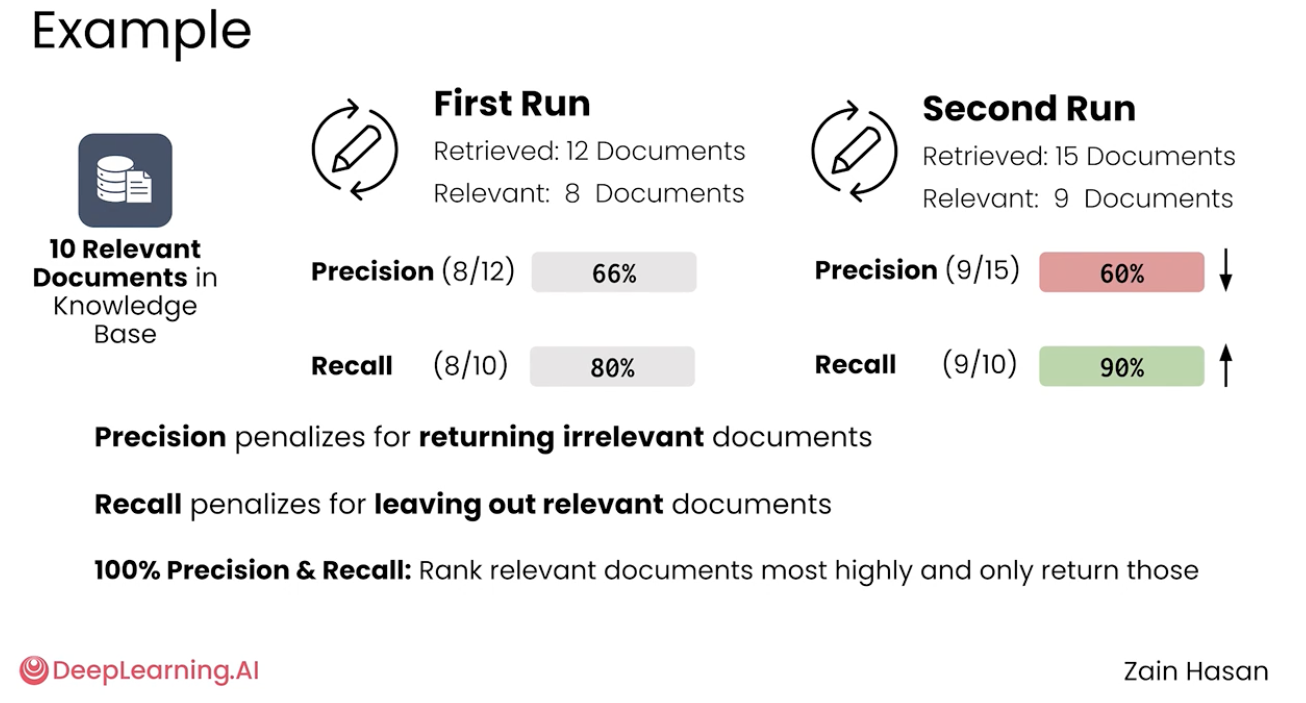 

### Advanced Metrics

`Mean Average Precision (MAP)` evaluates the average precision for relevant documents in the top K retrieved documents.

`Mean Reciprocal Rank (MRR)` measures how quickly relevant documents appear in the ranking, emphasizing the importance of their position.

We can use these metrics help evaluate retriever performance and guide adjustments to improve retrieval quality. The calculation is easy, the real challenge lies in compiling ground truth data for relevant documents, which is essential for accurate evaluation

## Code Example for Retriever Evaluation

First we need to get some data to evaluate the retriever. The 20 Newsgroups dataset is a popular dataset for text classification and clustering tasks. It contains approximately 20,000 newsgroup documents, partitioned across 20 different newsgroups. The dataset is widely used for benchmarking text classification algorithms and is available in various formats, including plain text and preprocessed versions.



In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.datasets import fetch_20newsgroups'

In [ ]:
newsgroups_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
print(type(newsgroups_train))
# Convert the dataset to a DataFrame for easier handling
# The following code creates a DataFrame from the newsgroups dataset, it contains two columns: 'text' and 'category'.
# .DataFrame() takes a dictionary with 'text' and 'category' as keys, where 'text' contains the document texts and 'category' contains the corresponding target labels as lists.
df = pd.DataFrame({
    'text': newsgroups_train.data,
    'category': newsgroups_train.target   
})

# Display some basic information about the dataset
print(df.head())

The "type" of the dataset is a `Bunch` object, which is a dictionary-like object that contains the data and metadata of the dataset. The `data` attribute contains the text documents, while the `target` attribute contains the labels for each document. 

The categories in the dataset can be accessed using the `target_names` attribute, which provides a list of the newsgroup names corresponding to the target labels. The dataset is commonly used for tasks such as text classification, clustering, and topic modeling, making it a valuable resource for evaluating text processing and machine learning algorithms.



In [25]:
print(f"TEXT:\n\t{df['text'][0]}\nCATEGORY:\n\t{newsgroups_train.target_names[df['category'][0]]}")
names = newsgroups_train.target_names

TEXT:
	From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





CATEGORY:
	rec.autos


In [24]:
print(f"Number of categories: {len(names)}")
[print(f"{names.index(name)+1}: {name}") for name in names]
print(f"Type of target_names: {type(newsgroups_train.target_names)}")

Number of categories: 20
1: alt.atheism
2: comp.graphics
3: comp.os.ms-windows.misc
4: comp.sys.ibm.pc.hardware
5: comp.sys.mac.hardware
6: comp.windows.x
7: misc.forsale
8: rec.autos
9: rec.motorcycles
10: rec.sport.baseball
11: rec.sport.hockey
12: sci.crypt
13: sci.electronics
14: sci.med
15: sci.space
16: soc.religion.christian
17: talk.politics.guns
18: talk.politics.mideast
19: talk.politics.misc
20: talk.religion.misc
Type of target_names: <class 'list'>


## Load the model

We can use the `SentenceTransformer` class from the `sentence_transformers` library to load a pre-trained model. 


In [27]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('BAAI/bge-base-en-v1.5') 

To vectorize the documents, we can use the `encode` method of the `SentenceTransformer` class. This method takes a list of documents as input and returns their vector representations.


In [31]:
embeddings = model.encode(df['text'].tolist(), show_progress_bar=True, convert_to_tensor=True)

Batches:   0%|          | 0/354 [00:00<?, ?it/s]

/Users/maggiezhao/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


## Prepare the data and functions

We need to do several things before we can evaluate the retriever:
1. Load the dataset and extract the documents and their labels.
2. Vectorize the documents using the pre-trained model.
3. Clean up the quries to remove any special characters or punctuation before vectorizing them.
4. Define a function to compute the cosine similarity between two vectors.

In [ ]:
def preprocess_text(text):
    """
    Preprocess the text data by removing leading and trailing whitespace.

    Parameters:
    text (str): The input text to preprocess.

    Returns:
    str: The preprocessed text, with leading and trailing whitespace removed.
    """
    # Example preprocessing: remove leading/trailing whitespace
    text = text.strip()
    return text


def cosine_similarity(v1, array_of_vectors):
    """
    Compute the cosine similarity between a vector and an array of vectors.

    Parameters:
    v1 (array-like): The first vector.
    array_of_vectors (array-like): An array of vectors or a single vector.

    Returns:
    list: A list of cosine similarities between v1 and each vector in array_of_vectors.
    """
    # Ensure that v1 is a numpy array
    if hasattr(v1, 'cpu'):
        v1 = v1.cpu().numpy()
    else:
        v1 = np.array(v1)
    # Initialize a list to store similarities
    similarities = []
    # Check if array_of_vectors is a single vector, if so, convert it to a list
    if len(np.shape(array_of_vectors)) == 1:
        array_of_vectors = [array_of_vectors]
    # Iterate over each vector in the array
    for v2 in array_of_vectors:
        # Convert the current vector to a numpy array
        if hasattr(v2, 'cpu'):
            v2 = v2.cpu().numpy()
        else:
            v2 = np.array(v2)
        # Compute the dot product of v1 and v2
        dot_product = np.dot(v1, v2)
        # Compute the norms of the vectors
        norm_v1 = np.linalg.norm(v1)
        norm_v2 = np.linalg.norm(v2)
        # Compute the cosine similarity and append to the list
        similarity = dot_product / (norm_v1 * norm_v2)
        similarities.append(similarity)
    return similarities
    # similarities is a list of cosine similarities between v1 and each vector in array_of_vectors


def top_k_greatest_indices(lst, k):
    """
    Get the indices of the top k greatest items in a list.

    Parameters:
    lst (list): The list of elements to evaluate.
    k (int): The number of top elements to retrieve by index.

    Returns:
    list: A list of indices corresponding to the top k greatest elements in lst.
    """
    # Enumerate the list to keep track of indices； enumerate() returns an iterator that produces pairs of index and value
    indexed_list = list(enumerate(lst))
    # Sort by element values in descending order, sorted() will sort the list from highest to lowest if reverse=True
    sorted_by_value = sorted(indexed_list, key=lambda x: x[1], reverse=True)
    # Extract the top k indices
    top_k_indices = [index for index, value in sorted_by_value[:k]]
    return top_k_indices

In [34]:
def retrieve_documents(query, embeddings, model, top_k=5):
    """
    Retrieve the top-k most similar documents to a given query based on cosine similarity.

    Parameters:
    query (str): The search query for which similar documents are to be retrieved.
    embeddings (list): A list of document embeddings against which the query is compared.
    model (object): A model with an 'encode' method to transform the query into an embedding.
    top_k (int, optional): The number of top documents to retrieve. Defaults to 5.

    Returns:
    None: Prints the most similar documents and their categories to the console.
    """
    # Preprocess and encode the query
    query_clean = preprocess_text(query)  # Clean the query by removing extra spaces
    query_embedding = model.encode(query_clean, convert_to_tensor=True)  # Encode the cleaned query

    # Compute cosine similarities between the query and the dataset embeddings
    cosine_scores = []
    for x in embeddings:
        # Append the similarity score of the query embedding against each document embedding
        cosine_scores.append(cosine_similarity(query_embedding, x))

    # Retrieve top-k documents; torch.topk returns the indices
    top_results = top_k_greatest_indices(cosine_scores, k=top_k)

    # Display the results
    print(f"Query: {query}")
    for x in top_results:
        # Print a snippet of the document text
        print(f"Document: {df.iloc[x]['text'][:200]}...")
        # Print the category of the document using its index
        print(f"Category: {newsgroups_train.target_names[df.iloc[x]['category']]}...")
        print("\n\n")

        
# Example query
example_query = "space exploration"
retrieve_documents(example_query, embeddings, model, top_k = 2)

Query: space exploration
Document: From: u1452@penelope.sdsc.edu (Jeff Bytof - SIO)
Subject: End of the Space Age?
Organization: San Diego Supercomputer Center @ UCSD
Lines: 16
Distribution: world
NNTP-Posting-Host: penelope.sdsc.edu

...
Category: sci.space...



Document: From: dennisn@ecs.comm.mot.com (Dennis Newkirk)
Subject: Space class for teachers near Chicago
Organization: Motorola
Distribution: usa
Nntp-Posting-Host: 145.1.146.43
Lines: 59

I am posting this for...
Category: sci.space...





## Retrieving Metrics

Precision can be calculated by comparing the retrieved documents against a set of relevant documents. In this case, we can use the `top_k` documents retrieved for the example query and check how many of them are relevant.

```math
Precision = \frac{\text{Number of Relevant Documents Retrieved}}{\text{Total Documents Retrieved}}
```

or 

```math
Precision = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
```

Then we have `recall`:

```math
Recall = \frac{\text{Number of Relevant Documents Retrieved}}{\text{Total Relevant Documents}}
```

or

```math
Recall = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
```



In [35]:
def precision(tp, tn, fp, fn):
    """
    Calculate the precision of a binary classification model.

    Precision is the ratio of true positives (TP) to the sum of true positives
    and false positives (FP), which indicates the accuracy of positive predictions.

    Args:
        tp (int): True positives.
        tn (int): True negatives (not used in precision calculation).
        fp (int): False positives.
        fn (int): False negatives (not used in precision calculation).

    Returns:
        float: The precision value, or 0.0 if the denominator is zero.
    
    Raises:
        ValueError: If any input is negative.
    """
    if tp < 0 or tn < 0 or fp < 0 or fn < 0:
        raise ValueError("All input values must be non-negative.")
    
    if tp + fp == 0:
        return 0.0

    return tp / (tp + fp)

In [36]:
def recall(tp, tn, fp, fn):
    """
    Calculate the recall (sensitivity) of a binary classification model.

    Recall is the ratio of true positives (TP) to the sum of true positives (TP)
    and false negatives (FN), measuring the ability to detect positive instances.

    Args:
        tp (int): True positives.
        tn (int): True negatives (not used in recall calculation).
        fp (int): False positives (not used in recall calculation).
        fn (int): False negatives.

    Returns:
        float: The recall value, or 0.0 if the denominator is zero.
    
    Raises:
        ValueError: If any input is negative.
    """
    if tp < 0 or tn < 0 or fp < 0 or fn < 0:
        raise ValueError("All input values must be non-negative.")

    if tp + fn == 0:
        return 0.0

    return tp / (tp + fn)

We also need to define a function to compute the cosine similarity between two vectors. This function will be used to calculate the similarity between the query vector and the document vectors.


In [49]:
# Define more complex test queries with their corresponding desired categories
test_queries = [
    {"query": "advancements in space exploration technology", "desired_category": "sci.space"},
    {"query": "real-time rendering techniques in computer graphics", "desired_category": "comp.graphics"},
    {"query": "latest findings in cardiovascular medical research", "desired_category": "sci.med"},
    {"query": "NHL playoffs and team performance statistics", "desired_category": "rec.sport.hockey"},
    {"query": "impacts of cryptography in online security", "desired_category": "sci.crypt"},
    {"query": "the role of electronics in modern computing devices", "desired_category": "sci.electronics"},
    {"query": "motorcycles maintenance tips for enthusiasts", "desired_category": "rec.motorcycles"},
    {"query": "high-performance baseball tactics for championships", "desired_category": "rec.sport.baseball"},
    {"query": "historical influence of politics on society", "desired_category": "talk.politics.misc"},
    {"query": "latest technology trends in the Windows operating system", "desired_category": "comp.os.ms-windows.misc"}
    
]


In [47]:
def compute_metrics(queries, embedding_vectors, model, top_k=5):
    """
    Compute precision and recall metrics for a list of queries against a dataset of document embeddings.

    Parameters:
    queries (list): A list of dictionaries, each containing a "query" and a "desired_category".
    embeddings (list): A list of document embeddings to which queries will be compared.
    model (object): A model with an 'encode' method to transform queries into embeddings.
    top_k (int, optional): The number of top documents to consider for each query. Defaults to 5.

    Returns:
    list: A list of dictionaries, each containing the query, its precision, and recall.
    """
    # Initialize a list to store computed metric results
    results = []
    
    # Iterate over each query in the queries list
    for item in queries:
        query = item["query"]
        desired_category = item["desired_category"]

        # Retrieve documents: preprocess and encode the query
        query_clean = preprocess_text(query)
        query_embedding = model.encode(query_clean, convert_to_tensor=True)

        # Compute cosine similarities with the dataset embeddings
        cosine_scores = []
        for x in embedding_vectors:
            cosine_scores.append(cosine_similarity(query_embedding, x))

        # Retrieve top-k documents based on cosine similarity
        top_results = top_k_greatest_indices(cosine_scores, k=top_k)

        # Check the categories of the retrieved documents
        retrieved_categories = [
            newsgroups_train.target_names[df.iloc[idx]["category"]] for idx in top_results
        ]
        
        # Calculate true positives and false positives
        true_positives = sum(1 for cat in retrieved_categories if cat == desired_category)
        false_positives = top_k - true_positives
        # Assume all other relevant documents in this context are false negatives
        false_negatives = sum(
            newsgroups_train.target_names[df.iloc[idx]["category"]] == desired_category 
            for idx in top_results
        ) - true_positives
        # TN (True Negatives) is generally not well-defined in this informational retrieval context
        true_negatives = 0

        # Calculate precision and recall using defined functions
        p = precision(true_positives, true_negatives, false_positives, false_negatives)
        r = recall(true_positives, true_negatives, false_positives, false_negatives)

        # Append the results to the list
        results.append({
            "query": query,
            "precision": p,
            "recall": r,
        })

    return results

In [48]:
# Run the queries and compute metrics
results = compute_metrics(test_queries, embeddings, model)

# Display the results
print("Results:")
for result in results:
    print(f"Query: {result['query']}, Precision: {result['precision']:.2f}, Recall: {result['recall']:.2f}")

Results:
Query: advancements in space exploration technology, Precision: 1.00, Recall: 1.00
Query: real-time rendering techniques in computer graphics, Precision: 1.00, Recall: 1.00
Query: latest findings in cardiovascular medical research, Precision: 1.00, Recall: 1.00
Query: NHL playoffs and team performance statistics, Precision: 1.00, Recall: 1.00
Query: impacts of cryptography in online security, Precision: 1.00, Recall: 1.00
Query: the role of electronics in modern computing devices, Precision: 1.00, Recall: 1.00
Query: motorcycles maintenance tips for enthusiasts, Precision: 1.00, Recall: 1.00
Query: high-performance baseball tactics for championships, Precision: 1.00, Recall: 1.00
Query: historical influence of politics on society, Precision: 0.40, Recall: 1.00
Query: latest technology trends in the Windows operating system, Precision: 0.80, Recall: 1.00


=======END=========